In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def build_up_b(rho, dt, dx, dy, u, v):
    b = numpy.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                                      (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                            ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                            2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                                 (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                            ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    # Periodic BC Pressure @ x = 2
    b[1:-1, -1] = (rho * (1 / dt * ((u[1:-1, 0] - u[1:-1,-2]) / (2 * dx) +
                                    (v[2:, -1] - v[0:-2, -1]) / (2 * dy)) -
                          ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx))**2 -
                          2 * ((u[2:, -1] - u[0:-2, -1]) / (2 * dy) *
                               (v[1:-1, 0] - v[1:-1, -2]) / (2 * dx)) -
                          ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))**2))

    # Periodic BC Pressure @ x = 0
    b[1:-1, 0] = (rho * (1 / dt * ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx) +
                                   (v[2:, 0] - v[0:-2, 0]) / (2 * dy)) -
                         ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))**2 -
                         2 * ((u[2:, 0] - u[0:-2, 0]) / (2 * dy) *
                              (v[1:-1, 1] - v[1:-1, -1]) / (2 * dx))-
                         ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))**2))
    
    return b
    
def pressure_poisson_periodic(p, dx, dy, b, nit=50):
    pn = numpy.empty_like(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])

        # Periodic BC Pressure @ x = 2
        p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, -1])

        # Periodic BC Pressure @ x = 0
        p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 0])
        
        # Wall boundary conditions, pressure
        p[-1, :] =p[-2, :]  # dp/dy = 0 at y = 2
        p[0, :] = p[1, :]  # dp/dy = 0 at y = 0
    
    return p

Initially, the divergence is -0.0. The bulk velocity is 1.795918630732439.
Solve step: 9, target: 2.0, result flow: 1.999384293306188, force: 1.693359375, error: 0.000615706693811946, using time: 2.6382622718811035
-0.0


AttributeError: 'NSControlEnv2D' object has no attribute 'eng'

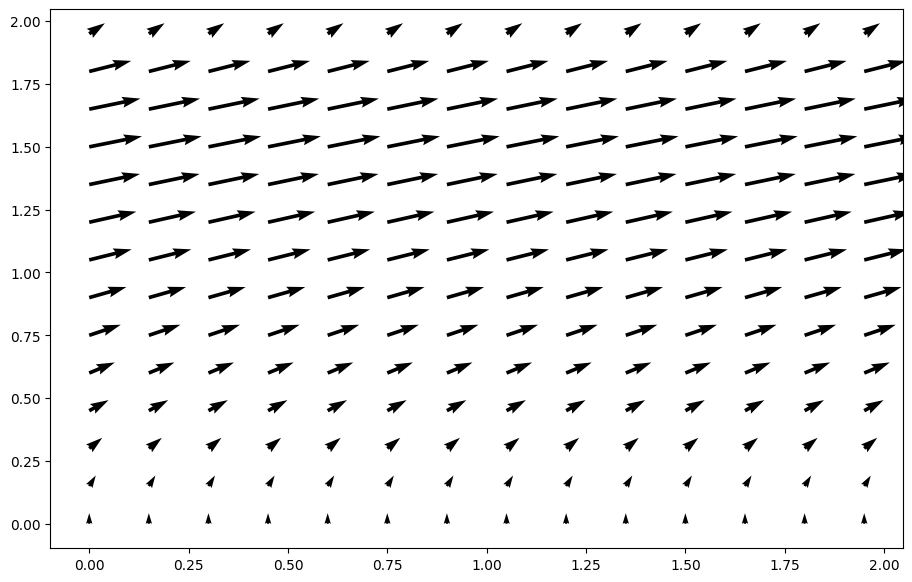

In [6]:
# import wandb
# import matlab.engine
# from libs.utilities3 import *
# from libs.visualization import *
import pdb
import copy
import time
import numpy as np
from sklearn.metrics import mean_squared_error
# from libs.env_util import to_m, relative_loss, apply_periodic_boundary


class NSControlEnv2D:
    def __init__(self, detect_plane, bc_type):
        self.detect_plane = detect_plane
        self.bc_type = bc_type

        # initialize system states
        self.nx = 41
        self.ny = 41
        self.nt = 10
        self.nit = 50
        self.c = 1
        self.dx = 2 / (self.nx - 1)
        self.dy = 2 / (self.ny - 1)
        self.x = np.linspace(0, 2, self.nx)
        self.y = np.linspace(0, 2, self.ny)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
        # physical variables, hyper-parameters
        self.rho = 1
        self.nu = .1
        self.F = 1.5
        self.dt = .01
        self.v_scale = 0.6
        
        # initial conditions
        self.u = np.zeros((self.ny, self.nx))
        self.un = np.zeros((self.ny, self.nx))
        
        self.v = np.ones((self.ny, self.nx)) * self.v_scale
        self.vn = np.ones((self.ny, self.nx)) * self.v_scale
        
        self.p = np.ones((self.ny, self.nx))

        self.bulk_v = self.solve(self.un, self.vn, self.p, self.u, self.v, self.dx, self.dy, self.dt, self.rho, self.nu, self.F, update_state=True)
        print(f"Initially, the divergence is {self.reward_div()}. The bulk velocity is {self.bulk_v}.")
        self.info_init = None

    '''
    State management
    '''
    def get_state(self):
        states = {
            'nx': self.nx,
            'ny': self.ny,
            'nt': self.nt,
            'nit': self.nit,
            'c': self.c,
            'dx': self.dx,
            'dy': self.dy,
            'x': self.x,
            'y': self.y,
            'X': self.X,
            'Y': self.Y,
            'rho': self.rho,
            'nu': self.nu,
            'F': self.F,
            'dt': self.dt,
            'v_scale': self.v_scale,
            'u': self.u,
            'un': self.un,
            'v': self.v,
            'vn': self.vn,
            'p': self.p,
        }
        return states

    def set_state(self, state):
        self.nx = state['nx']
        self.ny = state['ny']
        self.nt = state['nt']
        self.nit = state['nit']
        self.c = state['c']
        self.dx = state['dx']
        self.dy = state['dy']
        self.x = state['x']
        self.y = state['y']
        self.X = state['X']
        self.Y = state['Y']

        self.rho = state['rho']
        self.nu = state['nu']
        self.F = state['F']
        self.dt = state['dt']
        self.v_scale = state['v_scale']

        self.u = state['u']
        self.un = state['un']
        self.v = state['v']
        self.vn = state['vn']
        self.p = state['p']
        
    '''
    Calculating scores.
    '''
    def cal_bulk_v(self):
        return np.mean(abs(self.u))
        
    def cal_div(self):
        ux = (self.u[11, 10] - self.u[11, 9]) / self.dx
        uy = (self.v[11, 10] - self.v[10, 10]) / self.dy
        return ux + uy

    def cal_pressure(self,):
        return self.p
    
    def cal_dpdx_reverse(self, layer_index=-1):
        dpdx = self.eng.compute_dpdx_reverse(to_m(self.U), to_m(self.V), to_m(self.W), to_m(self.nu), 
                                             to_m(self.dx), to_m(self.dz), to_m(self.y), to_m(self.yg), 
                                             to_m(self.Ny))
        dpdx = np.array(dpdx)  # transfer to numpy array
        if layer_index == -1:
            dpdx = (dpdx[:, -1, :] + dpdx[:, -2, :]) / 2  # top pressure
        else:
            dpdx = dpdx[:, layer_index, :]
        dpdx = np.mean(abs(dpdx))
        return dpdx

    def cal_velocity_mean(self, velocity_name='U', sample_index=10):
        if velocity_name == 'U':
            all_velocity = self.U
        elif velocity_name == 'V':
            all_velocity = self.V
        elif velocity_name == 'W':
            all_velocity = self.W
        else:
            raise RuntimeError("not supported velocity!")
        if sample_index is not None:
            velocity = abs(all_velocity)[:, -sample_index:, :].mean()
        else:
            velocity = abs(all_velocity).mean()
        return velocity
 
    def cal_speed_norm(self, ):
        return np.linalg.norm(self.V) + np.linalg.norm(self.U) + np.linalg.norm(self.W)
    
    def cal_dudy(self, ):
        dudy_all = []
        for select_index in range(self.U.shape[1] - 2):
            dudy = (self.U[:, select_index + 1, :] - self.U[:, select_index, :]) / \
            (self.y[select_index + 1][0] - self.y[select_index][0])
            dudy_all.append(dudy)
        return dudy_all
    
    def cal_shear_stress(self, ):
        # -u*v + nu * (dU/dy)
        wall_u = self.U[:, -1, :]
        wall_v = self.V[:, -1, :]
        dudy_all = self.cal_dudy()
        dudy = dudy_all[-1]
        first_term = -wall_u * wall_v
        second_term = self.nu * dudy
        shear_stress = first_term + second_term
        shear_stress_mean = np.mean(shear_stress)
        shear_stress_res = abs(shear_stress_mean)
        return shear_stress_res
    
    def reward_div(self, bound=-100):
        reward = - abs(np.sum(self.cal_div()))
        if reward < bound:
            reward = bound
        return reward

    def reward_gt(self, bound=-100):
        reward = 0
        reward -= relative_loss(self.U_gt.flatten(), self.U.flatten())
        reward -= relative_loss(self.V_gt.flatten(), self.V.flatten())
        reward -= relative_loss(self.W_gt.flatten(), self.W.flatten())
        if reward < bound:
            reward = bound
        return reward

    def reward_td(self, prev_U, prev_V, prev_W, bound=-100):
        reward = 0
        reward -= relative_loss(prev_U.flatten(), self.U.flatten())
        reward -= relative_loss(prev_V.flatten(), self.V.flatten())
        reward -= relative_loss(prev_W.flatten(), self.W.flatten())
        if reward < bound:
            reward = bound
        return reward

    def cal_relative_info(self, info):
        if self.info_init is None:
            self.info_init = info
            return {}
        else:
            relative_dict = {}
            for one_k in info:
                new_k = one_k.replace("drag_reduction", "drag_reduction_relative")
                relative_dict[new_k] = info[one_k] / self.info_init[one_k]
            return relative_dict
    
    # def get_state(self):
    #     next_state = self.p[-1, :]
    #     return next_state
    
    '''
    Visualizations
    '''
    
    def vis_state(self, vis_img=False, sample_slice_top=15, sample_slice_others=10):
        fig = pyplot.figure(figsize = (11,7), dpi=100)
        pyplot.quiver(self.X[::3, ::3], self.Y[::3, ::3], self.u[::3, ::3], self.v[::3, ::3])
        # TODO: finish this function
        # pressure = self.cal_pressure()
        # cut_dim = self.U.shape[0]
        # # get front view
        # mid_index = pressure.shape[2] // sample_slice_others
        # front_pressure = pressure[:, -cut_dim:, mid_index].transpose()
        # u_in_xy = self.U[:, -cut_dim:, mid_index].transpose() / 10000
        # v_in_xy = self.V[:, -cut_dim:, mid_index].transpose()
        # front_view = visualize_pressure_speed(front_pressure, pressure_min=-0.01, pressure_max=0.01, \
        #     speed_horizontal=u_in_xy, speed_vertical=v_in_xy, vis_img=vis_img, vis_name='front', quiver_scale=0.03, \
        #     x_sample_interval=2, y_sample_interval=2, v_flip=False)

        # # TODO: check top view and side view visualizations' order
        # # get top view
        # mid_index = pressure.shape[1] // sample_slice_top
        # top_pressure = np.squeeze(-0.5 * (pressure[:, -1, :] + pressure[:, -2, :]))
        # u_in_xz = self.U[:, -mid_index, :] - self.U[:, -mid_index, :].mean()
        # w_in_xz = self.W[:, -mid_index, :]
        # top_view = visualize_pressure_speed(top_pressure, pressure_min=-0.03, pressure_max=0.03, \
        #     speed_horizontal=u_in_xz, speed_vertical=w_in_xz, vis_img=vis_img, quiver_scale=0.05, vis_name='top',)

        # # get side view
        # sample_index = pressure.shape[0] // sample_slice_others
        # side_pressure = pressure[sample_index, :cut_dim, :]
        # v_in_yz = self.V[sample_index, :cut_dim, :]
        # w_in_yz = self.W[sample_index, :cut_dim, :]
        # side_view = visualize_pressure_speed(side_pressure, pressure_min=-0.005, pressure_max=0.005, \
        #     speed_horizontal=w_in_yz, speed_vertical=v_in_yz, vis_img=vis_img, vis_name='side', \
        #         quiver_scale=0.03, x_sample_interval=2, y_sample_interval=2)
        # if vis_img:
        #     import pdb; pdb.set_trace()
        # return top_view, front_view, side_view
    
    def plot_spatial_distribution(self, step_index):
        info = {}
        dpdx = self.eng.compute_dpdx_reverse(to_m(self.U), to_m(self.V), to_m(self.W), to_m(self.nu), 
                                             to_m(self.dx), to_m(self.dz), to_m(self.y), to_m(self.yg), 
                                             to_m(self.Ny))
        dpdx = np.array(dpdx)  # transfer to numpy array
        dudy_all = self.cal_dudy()
        dpdx_all = abs(dpdx)
        for chart_key in ['U', 'V', 'W', 'dudy', 'dpdx_reverse']:
            cur_data = []
            for sample_index in range(30):
                if chart_key in ['U', 'V', 'W']:
                    value_name = chart_key + "_velocity"
                    value = self.cal_velocity_mean(chart_key, sample_index=-sample_index)
                elif chart_key == 'dudy':
                    value_name = 'dudy'
                    value = np.mean(abs(dudy_all[-sample_index]))
                elif chart_key == 'dpdx_reverse':
                    value_name = 'dpdx_reverse'
                    value = np.mean(dpdx_all[:, -sample_index, :])
                else:
                    raise RuntimeError()
                cur_data.append([sample_index, value])
                
            # Create a table with the columns to plot
            table = wandb.Table(data=cur_data, columns=["layer index", value_name])

            # Use the table to populate various custom charts
            line_plot = wandb.plot.line(table, x="layer index", y=value_name, title="y-aixs distribution of " + value_name)
            info['spatial_dist/' + str(step_index) + "/" + value_name] = line_plot
        wandb.log(info)
        return
    
    '''
    Control policies.
    '''
    
    def rand_control(self, P):
        opV2 = self.eng.compute_opposition(to_m(P))
        opV2 = np.array(opV2)
        return opV2
    
    def gt_control(self):
        opV2 = self.V[:, self.detect_plane, :]
        return np.array(opV2)

    def apply_bc(self, opV2):
        if opV2 is None:  # 'unmanipulated'
            return
        if self.bc_type == 'original':
            opV2 = - opV2 # apply opposition here
            opV2 = opV2 - np.mean(opV2)
            opV1 = opV2 * 0
            
            # Applying boundary conditions for U
            self.U[:, 0, :] = -self.U[:, 1, :]
            self.U[:, -1, :] = -self.U[:, -2, :]
            # Applying boundary conditions for V
            self.V[:, 0, :] = opV1
            self.V[:, -1, :] = opV2
            
            # Applying boundary conditions for W
            self.W[:, 0, :] = -self.W[:, 1, :]
            self.W[:, -1, :] = -self.W[:, -2, :]
        elif self.bc_type == 'zero_w':
            opV2 = - opV2 # apply opposition here
            opV2 = opV2 - np.mean(opV2)
            opV1 = opV2 * 0
            # Applying boundary conditions for U
            self.U[:, 0, :] = self.U[:, -1, :]
            # Applying boundary conditions for V
            self.V[:, 0, :] = opV1
            self.V[:, -1, :] = opV2
            # Apply boundary counditions for W
            self.W *= self.w_weight
        elif self.bc_type == 'zero_bound':
            opV2 = - opV2 # apply opposition here
            opV2 = opV2 - np.mean(opV2)
            opV1 = opV2 * 0
            
            # Applying boundary conditions for U
            self.U[:, 0, :] = -self.U[:, 1, :]
            self.U[:, -1, :] = -self.U[:, -2, :]
            # Applying boundary conditions for V
            self.V[:, 0, :] = opV1
            self.V[:, -1, :] = opV2
            
            # Apply boundary counditions for W
            self.W[0, :, :] = 0
            self.W[-1, :, :] = 0
            self.W[:, 0, :] = 0
            self.W[:, -1, :] = 0
            self.W[:, :, 0] = 0
            self.W[:, :, -1] = 0
        elif self.bc_type == 'choi':
            opV2 = - opV2 # apply opposition here
            opV2 = opV2 - np.mean(opV2)
            
            # Applying boundary conditions for U
            self.U[-1, :, :] = self.U[0, :, :]
            self.U[:, :, -1] = self.U[:, :, 0]

            # Applying boundary conditions for V
            self.V[:, -1, :] = opV2
            self.V[:, 0, :] = 0

            # Apply boundary counditions for W
            self.W[0, :, :] = 0
            self.W[-1, :, :] = 0
            self.W[:, 0, :] = 0
            self.W[:, -1, :] = 0
            self.W[:, :, 0] = 0
            self.W[:, :, -1] = 0
        elif self.bc_type == 'eng':
            U, V, W = self.eng.apply_boundary_condition(to_m(self.U), to_m(self.V), to_m(self.W), 
                                                        -0*opV1, to_m(opV2), nargout=3)
            self.U, self.V, self.W = np.array(U), np.array(V), np.array(W)
        else:
            raise RuntimeError("Not supported BC type.")

    def solve(self, un_copy, vn_copy, p_copy, u_copy, v_copy, dx, dy, dt, rho, nu, F, update_state):
        """
        Solves the fluid flow simulation using the specified inputs.
    
        Args:
            un (ndarray): Input array for un.
            vn (ndarray): Input array for vn.
            p (ndarray): Input array for p.
            u (ndarray): Input array for u.
            v (ndarray): Input array for v.
            dx (float): Grid spacing in the x-direction.
            dy (float): Grid spacing in the y-direction.
            dt (float): Time step size.
            rho (float): Density.
            nu (float): Viscosity.
            F (float): Force.
            update_state (bool): Flag to update the class variables. Defaults to True.
    
        Returns:
            float: Bulk velocity.
        """
        p = copy.deepcopy(p_copy)
        u = copy.deepcopy(u_copy)
        v = copy.deepcopy(v_copy)
        udiff = 1.0
        stepcount = 0
        while udiff > .001:
            # Wall BC: u,v = 0 @ y = 0,2
            # u[0, :] = 0
            # u[-1, :] = 0
            # v[0, :] = -v[10, :]
            # v[-1, :]= -v[-10, :]
            
            un = u.copy()
            vn = v.copy()
            b = build_up_b(rho, dt, dx, dy, u, v)
            b = np.zeros_like(u)
            p = pressure_poisson_periodic(p, dx, dy, b, self.nit)
        
            u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                             un[1:-1, 1:-1] * dt / dx * 
                            (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                             vn[1:-1, 1:-1] * dt / dy * 
                            (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                             dt / (2 * rho * dx) * 
                            (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                             nu * (dt / dx**2 * 
                            (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                             dt / dy**2 * 
                            (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                             F * dt)
        
            v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                             un[1:-1, 1:-1] * dt / dx * 
                            (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                             vn[1:-1, 1:-1] * dt / dy * 
                            (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                             dt / (2 * rho * dy) * 
                            (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                             nu * (dt / dx**2 *
                            (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                             dt / dy**2 * 
                            (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        
            # Periodic BC u @ x = 2     
            u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                          (un[1:-1, -1] - un[1:-1, -2]) -
                           vn[1:-1, -1] * dt / dy * 
                          (un[1:-1, -1] - un[0:-2, -1]) -
                           dt / (2 * rho * dx) *
                          (p[1:-1, 0] - p[1:-1, -2]) + 
                           nu * (dt / dx**2 * 
                          (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                           dt / dy**2 * 
                          (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)
        
            # Periodic BC u @ x = 0
            u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                         (un[1:-1, 0] - un[1:-1, -1]) -
                          vn[1:-1, 0] * dt / dy * 
                         (un[1:-1, 0] - un[0:-2, 0]) - 
                          dt / (2 * rho * dx) * 
                         (p[1:-1, 1] - p[1:-1, -1]) + 
                          nu * (dt / dx**2 * 
                         (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                          dt / dy**2 *
                         (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)
        
            # Periodic BC v @ x = 2
            v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                          (vn[1:-1, -1] - vn[1:-1, -2]) - 
                           vn[1:-1, -1] * dt / dy *
                          (vn[1:-1, -1] - vn[0:-2, -1]) -
                           dt / (2 * rho * dy) * 
                          (p[2:, -1] - p[0:-2, -1]) +
                           nu * (dt / dx**2 *
                          (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                           dt / dy**2 *
                          (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))
        
            # Periodic BC v @ x = 0
            v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                         (vn[1:-1, 0] - vn[1:-1, -1]) -
                          vn[1:-1, 0] * dt / dy *
                         (vn[1:-1, 0] - vn[0:-2, 0]) -
                          dt / (2 * rho * dy) * 
                         (p[2:, 0] - p[0:-2, 0]) +
                          nu * (dt / dx**2 * 
                         (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                          dt / dy**2 * 
                         (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))
            udiff = (numpy.sum(u) - numpy.sum(un)) / numpy.sum(u)
            stepcount += 1
            if stepcount > 5000:
                raise RuntimeError("Not converged solving!")
    
        bulk_v = np.mean(abs(u))
        if update_state:
            self.un = un
            self.vn = vn
            self.p = p
            self.u = u
            self.v = v
            self.dx = dx
            self.dy = dy
            self.dt = dt
            self.rho = rho
            self.nu = nu
            self.F = F
        return bulk_v
    
    def solve_fixed_mass(self, target_flow, min_f=0.0, max_f=3.0, max_step=500, error_threshold=1e-3,
                        verbose=True):        
        solve_begin_t = time.time()
        un_copy = copy.deepcopy(self.un)
        vn_copy = copy.deepcopy(self.vn)
        p_copy = copy.deepcopy(self.p)
        u_copy = copy.deepcopy(self.u)
        v_copy = copy.deepcopy(self.v)
        dx_copy = copy.deepcopy(self.dx)
        dy_copy = copy.deepcopy(self.dy)
        dt_copy = copy.deepcopy(self.dt)
        rho_copy = copy.deepcopy(self.rho)
        nu_copy = copy.deepcopy(self.nu)
        # tuning self.F to keep mass flow rate constant
        min_flow = self.solve(un_copy, vn_copy, p_copy, u_copy, v_copy, dx_copy, dy_copy, dt_copy, rho_copy, nu_copy, min_f, update_state=False)
        max_flow = self.solve(un_copy, vn_copy, p_copy, u_copy, v_copy, dx_copy, dy_copy, dt_copy, rho_copy, nu_copy, max_f, update_state=False)
        assert target_flow >= min_flow, f"flow too small! at least if should be {min_flow}"
        assert target_flow <= max_flow, f"flow too large! at least it should be {max_flow}"
        step = 0
        error = float('inf')
        result_f = None
        v = 0
        while step < max_step and error > error_threshold:
            mid_f = (min_f + max_f) / 2  # Calculate the midpoint
    
            # Calculate the velocity at the midpoint force
            v = self.solve(un_copy, vn_copy, p_copy, u_copy, v_copy, dx_copy, dy_copy, dt_copy, rho_copy, nu_copy, mid_f, update_state=False)
    
            error = abs(v - target_flow)  # Calculate the error
    
            if v < target_flow:
                min_f = mid_f  # Adjust the lower bound if the velocity is lower than the target
            else:
                max_f = mid_f  # Adjust the upper bound if the velocity is higher than the target
    
            result_f = mid_f  # Update the result with the current midpoint
            step += 1  # Increment the step counter
        if verbose:
            print(f"Solve step: {step}, target: {target_flow}, result flow: {v}, force: {result_f}, error: {error}, using time: {time.time() - solve_begin_t}")
        return result_f, v, error
        
    def step(self, opV2):
        # Perform one step in the environment
        # Update state, calculate reward, check termination condition, etc.
        # Return the next state, reward, termination flag, and additional info
        prev_U, prev_V = self.u.copy(), self.v.copy()
        self.apply_bc(opV2)
        self.vis_state()
        self.solve_fixed_mass(target_flow=2.0)
        pressure_top = self.get_state()
        div = self.reward_div()
        print(div)
        dpdx_reverse  = self.cal_dpdx_reverse()
        # bulk_velocity = 2 - shear_velocity
        u_velocity = self.cal_velocity_mean('U', sample_index=None)
        v_velocity = self.cal_velocity_mean('V', sample_index=None)
        w_velocity = self.cal_velocity_mean('W', sample_index=None)
        pressure_mean = pressure_top.mean()
        gt_diff = self.reward_gt()
        speed_diff = self.reward_td(prev_U, prev_V, prev_W)
        speed_norm = self.cal_speed_norm()
        shear_stress = self.cal_shear_stress()
        done = False
        info = {
                'drag_reduction/1_shear_stress': shear_stress,
                'drag_reduction/2_1_mass_flow': u_velocity,
                'drag_reduction/2_2_v_velocity': v_velocity,
                'drag_reduction/2_3_w_velocity': w_velocity,
                'drag_reduction/3_1_pressure_mean': pressure_mean,
                'drag_reduction/3_2_dPdx_finite_difference': dpdx_finite_difference,
                'drag_reduction/3_3_dPdx_reverse_cal': dpdx_reverse,
                'drag_reduction/4_1_-|divergence|': div, 
                'drag_reduction/4_2_-|now - unnoised| ÷ ｜now|': gt_diff, 
                'drag_reduction/4_3_-|now - prev| ÷ |now|': speed_diff, 
                'drag_reduction/4_4_speed_norm': speed_norm,
                }
        norm_info = self.cal_relative_info(info)
        info.update(norm_info)
        return pressure_top, div, done, info

env = NSControlEnv2D(detect_plane=-10, bc_type='original')
control_step = 1
for i in range(control_step):
    env.step(opV2=None)

In [185]:
env.u[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

0.9578232697239683


(41, 41)

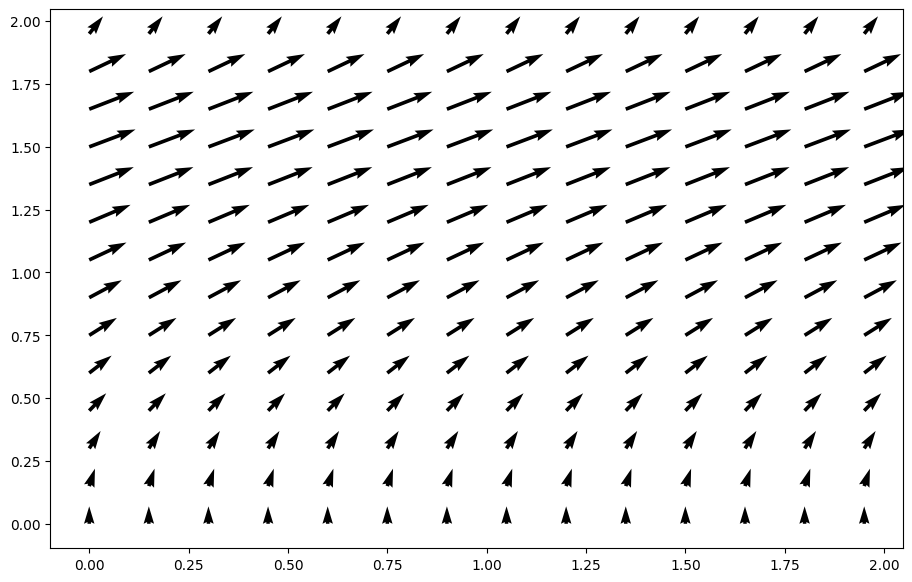

In [155]:


while udiff > .001:
    # Wall BC: u,v = 0 @ y = 0,2
    u[0, :] = 0
    u[-1, :] = 0
    # v[0, :] = -v[10, :]
    # v[-1, :]= -v[-10, :]
    
    un = u.copy()
    vn = v.copy()

    p = pressure_poisson_periodic(p, dx, dy)

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * (dt / dx**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                     F * dt)

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * rho * dy) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    # Periodic BC u @ x = 2     
    u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                  (un[1:-1, -1] - un[1:-1, -2]) -
                   vn[1:-1, -1] * dt / dy * 
                  (un[1:-1, -1] - un[0:-2, -1]) -
                   dt / (2 * rho * dx) *
                  (p[1:-1, 0] - p[1:-1, -2]) + 
                   nu * (dt / dx**2 * 
                  (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                   dt / dy**2 * 
                  (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

    # Periodic BC u @ x = 0
    u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (un[1:-1, 0] - un[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy * 
                 (un[1:-1, 0] - un[0:-2, 0]) - 
                  dt / (2 * rho * dx) * 
                 (p[1:-1, 1] - p[1:-1, -1]) + 
                  nu * (dt / dx**2 * 
                 (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                  dt / dy**2 *
                 (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

    # Periodic BC v @ x = 2
    v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                  (vn[1:-1, -1] - vn[1:-1, -2]) - 
                   vn[1:-1, -1] * dt / dy *
                  (vn[1:-1, -1] - vn[0:-2, -1]) -
                   dt / (2 * rho * dy) * 
                  (p[2:, -1] - p[0:-2, -1]) +
                   nu * (dt / dx**2 *
                  (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                   dt / dy**2 *
                  (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

    # Periodic BC v @ x = 0
    v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (vn[1:-1, 0] - vn[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy *
                 (vn[1:-1, 0] - vn[0:-2, 0]) -
                  dt / (2 * rho * dy) * 
                 (p[2:, 0] - p[0:-2, 0]) +
                  nu * (dt / dx**2 * 
                 (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                  dt / dy**2 * 
                 (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))
    udiff = (numpy.sum(u) - numpy.sum(un)) / numpy.sum(u)
    stepcount += 1
print(np.mean(abs(u)))
fig = pyplot.figure(figsize = (11,7), dpi=100)
pyplot.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3]);

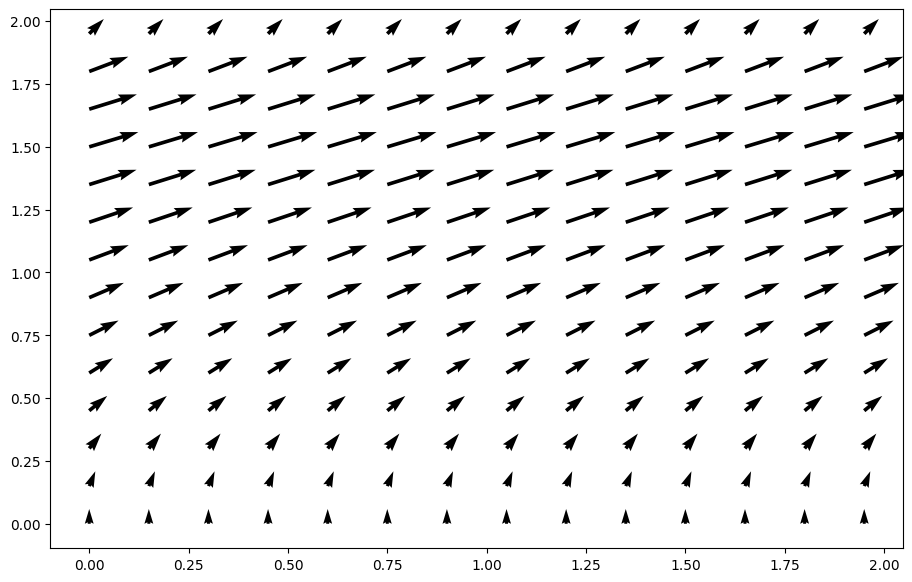

In [149]:
##variable declarations
nx = 41
ny = 41
nt = 10
nit = 50 
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)


##physical variables
rho = 1
nu = .1
F = 1
dt = .01

#initial conditions
u = numpy.zeros((ny, nx))
un = numpy.zeros((ny, nx))

v = numpy.ones((ny, nx)) * 0.6
vn = numpy.ones((ny, nx)) * 0.6

p = numpy.ones((ny, nx))
pn = numpy.ones((ny, nx))

# b = numpy.zeros((ny, nx))
udiff = 1
stepcount = 0

while udiff > .001:
    # Wall BC: u,v = 0 @ y = 0,2
    u[0, :] = 0
    u[-1, :] = 0
    # v[0, :] = -v[10, :]
    # v[-1, :]= -v[-10, :]
    
    un = u.copy()
    vn = v.copy()

    # b = build_up_b(rho, dt, dx, dy, u, v)
    p = pressure_poisson_periodic(p, dx, dy)

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * (dt / dx**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                     F * dt)

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * rho * dy) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    # Periodic BC u @ x = 2     
    u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                  (un[1:-1, -1] - un[1:-1, -2]) -
                   vn[1:-1, -1] * dt / dy * 
                  (un[1:-1, -1] - un[0:-2, -1]) -
                   dt / (2 * rho * dx) *
                  (p[1:-1, 0] - p[1:-1, -2]) + 
                   nu * (dt / dx**2 * 
                  (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                   dt / dy**2 * 
                  (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

    # Periodic BC u @ x = 0
    u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (un[1:-1, 0] - un[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy * 
                 (un[1:-1, 0] - un[0:-2, 0]) - 
                  dt / (2 * rho * dx) * 
                 (p[1:-1, 1] - p[1:-1, -1]) + 
                  nu * (dt / dx**2 * 
                 (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                  dt / dy**2 *
                 (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

    # Periodic BC v @ x = 2
    v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                  (vn[1:-1, -1] - vn[1:-1, -2]) - 
                   vn[1:-1, -1] * dt / dy *
                  (vn[1:-1, -1] - vn[0:-2, -1]) -
                   dt / (2 * rho * dy) * 
                  (p[2:, -1] - p[0:-2, -1]) +
                   nu * (dt / dx**2 *
                  (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                   dt / dy**2 *
                  (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

    # Periodic BC v @ x = 0
    v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (vn[1:-1, 0] - vn[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy *
                 (vn[1:-1, 0] - vn[0:-2, 0]) -
                  dt / (2 * rho * dy) * 
                 (p[2:, 0] - p[0:-2, 0]) +
                  nu * (dt / dx**2 * 
                 (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                  dt / dy**2 * 
                 (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))
    
    udiff = (numpy.sum(u) - numpy.sum(un)) / numpy.sum(u)
    stepcount += 1
fig = pyplot.figure(figsize = (11,7), dpi=100)
pyplot.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3]);